In [ ]:
# Importation des librairies nécessaires

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')  # Pour éviter les messages d'avertissement

In [6]:
train = pd.read_csv(r'C:\Users\kadas\Desktop\challenge_Data_mining\data\train.csv')
test = pd.read_csv(r'C:\Users\kadas\Desktop\challenge_Data_mining\data\test.csv')

print("Train Data:")
print(train.head())

Train Data:
   id  CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
0   0  15713774.0      Hsieh        683.0   Germany    Male  49.0     7.0   
1   1  15682533.0      Hs?eh        608.0    France  Female  30.0    10.0   
2   2  15791550.0       Tsou        539.0    France  Female  32.0     8.0   
3   3  15762762.0  Chiawuotu        530.0     Spain  Female  39.0     8.0   
4   4  15756475.0     Nnamdi        613.0    France  Female  45.0    10.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0  123837.86            2.0        1.0             1.0        138700.75   
1       0.00            2.0        1.0             1.0        146723.72   
2       0.00            1.0        1.0             1.0         94873.60   
3       0.00            2.0        0.0             0.0        177896.93   
4       0.00            2.0        1.0             1.0        116748.14   

   Exited  
0     1.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  


In [7]:
# Sauvegarde de l'identifiant
id = train['id'].copy()

In [8]:
# Suppression des colonnes inutiles
train = train.drop(columns=['id', 'CustomerId', 'Surname'])

In [9]:
# Statistiques descriptives
train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,658.701800,37.660800,5.038800,42888.826095,1.589467,0.779800,0.497867,117892.175400,0.199333
std,80.238346,8.106408,2.810354,59695.877791,0.532430,0.414395,0.500012,45574.462515,0.399512
min,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,602.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,82870.750000,0.000000
50%,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123583.850000,0.000000
75%,709.000000,42.000000,7.000000,109844.810000,2.000000,1.000000,1.000000,157567.370000,0.000000
max,4818.000000,72.000000,10.000000,207034.960000,6.000000,1.000000,1.000000,199761.290000,1.000000


# CreditScore

In [10]:
outliers_creditscore = train[train['CreditScore'] > 850]
print(outliers_creditscore)

       CreditScore Geography  Gender   Age  Tenure  Balance  NumOfProducts  \
11889       4818.0    France  Female  41.0     1.0      0.0            2.0   

       HasCrCard  IsActiveMember  EstimatedSalary  Exited  
11889        1.0             1.0         73418.29     0.0  


On observe la présence d'un outlier avec un max de 4818, ce qui est bien au-delà de ce qui est attendu pour un score de crédit (généralement compris entre 300 et 850). Nous décidons donc de lui imputer la médiane car cela ne présente pas de biais pour une seule observation parmi 15000.

In [11]:
# Calcul de la médiane des CreditScore valides
median_score = train[train['CreditScore'] <= 850]['CreditScore'].median()

# Imputation de la valeur aberrante par la médiane
train.loc[train['CreditScore'] > 850, 'CreditScore'] = median_score

# Vérification après imputation
print("Données après imputation :")
print(train['CreditScore'].describe())

Données après imputation :
count    15000.000000
mean       658.424667
std         72.696090
min        431.000000
25%        602.000000
50%        661.000000
75%        709.000000
max        850.000000
Name: CreditScore, dtype: float64


In [12]:
print(train.dtypes)

CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object


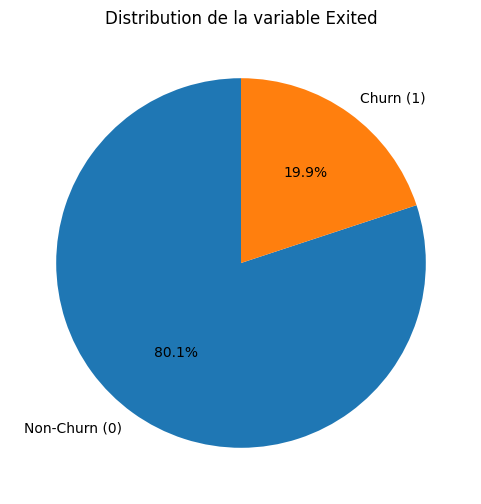

In [13]:
# Comptage des valeurs de `Exited`
exited_counts = train['Exited'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(exited_counts, labels=['Non-Churn (0)', 'Churn (1)'], autopct='%1.1f%%', startangle=90)
plt.title("Distribution de la variable Exited")
plt.show()

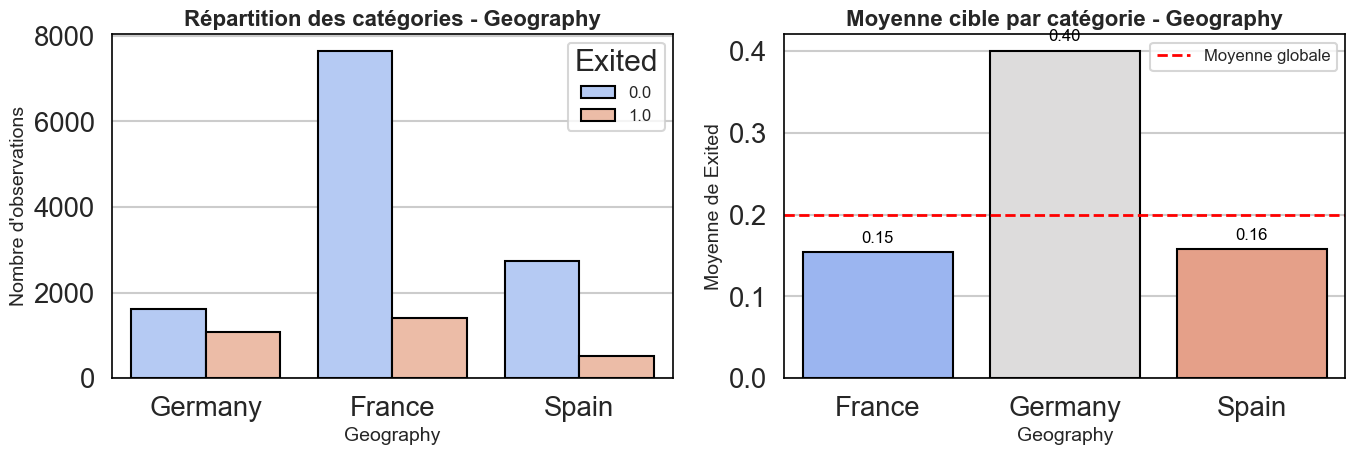

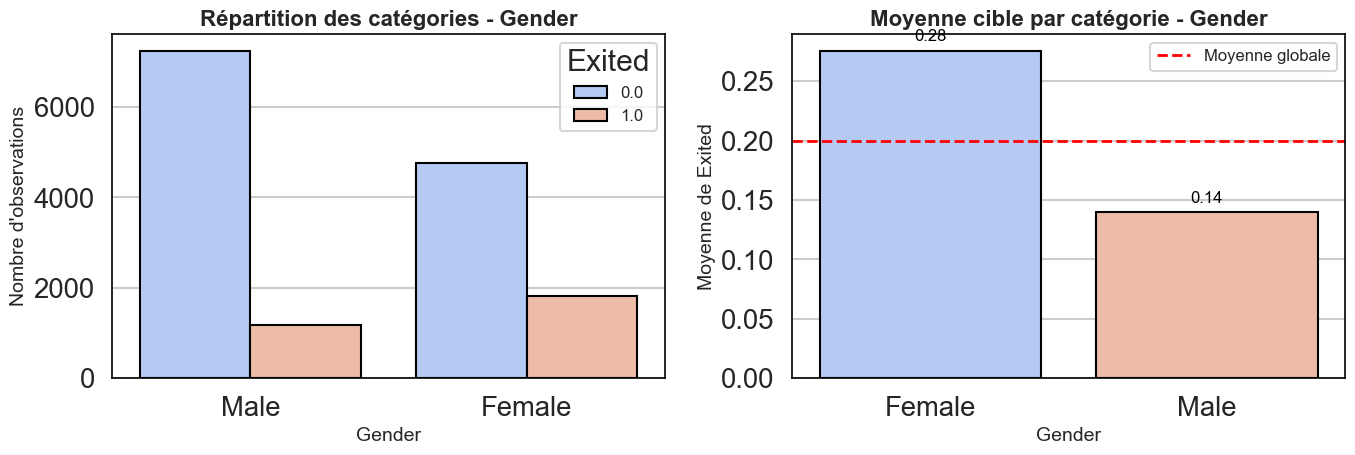

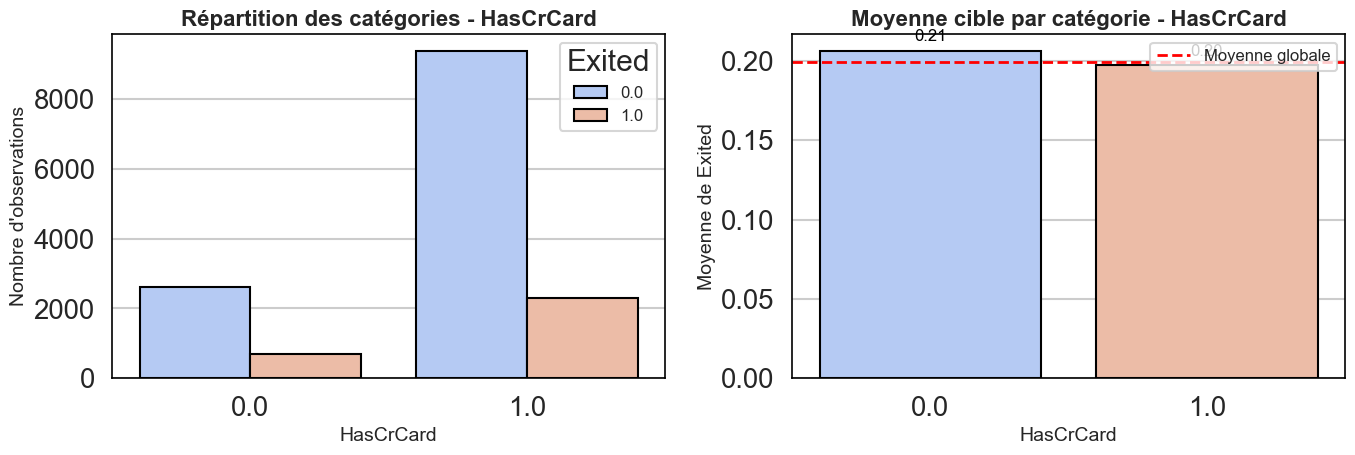

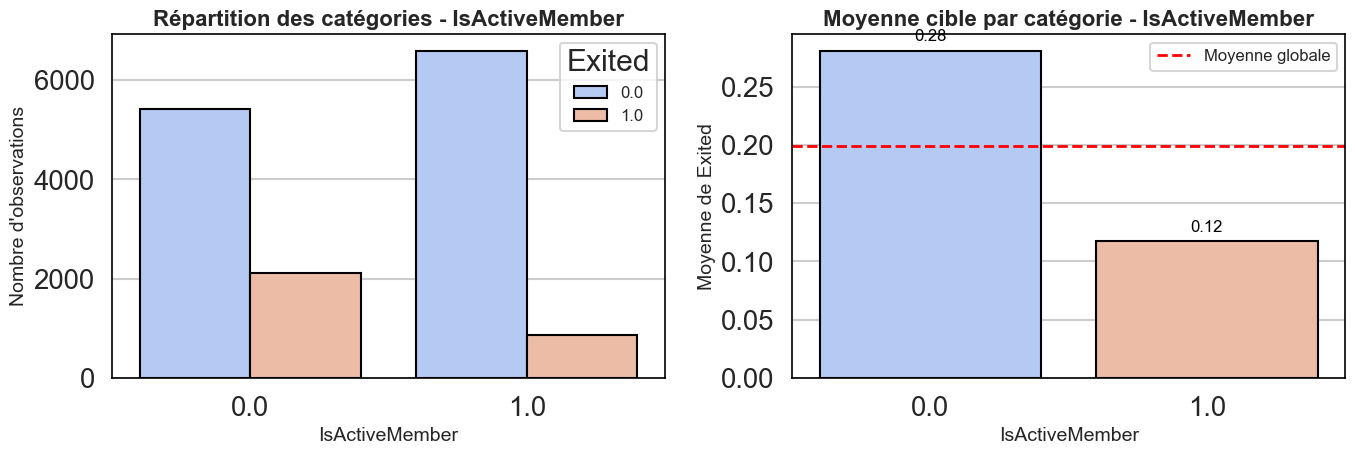

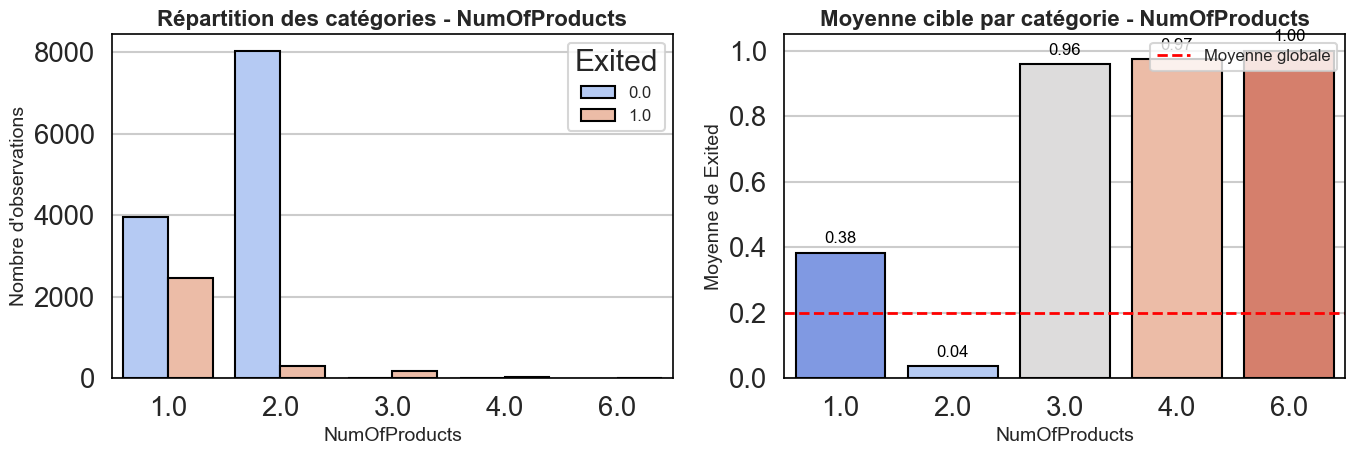

In [15]:


# Configuration esthétique générale
sns.set(style="whitegrid", context="talk", font_scale=1.2)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2

# Variables catégoriques
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']

# Moyenne globale de la cible
global_mean = train['Exited'].mean()

# Générer des graphiques pour chaque variable catégorique
for col in categorical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 2]})
    
    # Graphique 1 : Countplot
    ax1 = axes[0]
    sns.countplot(data=train, x=col, hue='Exited', palette='coolwarm', ax=ax1, linewidth=1.5, edgecolor="black")
    ax1.set_title(f"Répartition des catégories - {col}", fontsize=16, fontweight="bold")
    ax1.set_xlabel(f"{col}", fontsize=14)
    ax1.set_ylabel("Nombre d'observations", fontsize=14)
    ax1.legend(title="Exited", fontsize=12, loc="upper right", fancybox=True)
    
    # Graphique 2 : Moyenne cible
    ax2 = axes[1]
    category_means = train.groupby(col)['Exited'].mean()
    sns.barplot(x=category_means.index, y=category_means.values, palette='coolwarm', ax=ax2, edgecolor="black")
    ax2.axhline(global_mean, color='red', linestyle='--', linewidth=2, label='Moyenne globale')
    ax2.set_title(f"Moyenne cible par catégorie - {col}", fontsize=16, fontweight="bold")
    ax2.set_xlabel(f"{col}", fontsize=14)
    ax2.set_ylabel("Moyenne de Exited", fontsize=14)
    ax2.legend(fontsize=12, loc="upper right", fancybox=True)
    
    # Ajouter des annotations sur les barres
    for p in ax2.patches:
        ax2.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black',
                     xytext=(0, 10), textcoords='offset points')
    
    # Ajuster les espaces
    plt.tight_layout()
    plt.show()

In [17]:
from sklearn.preprocessing import LabelEncoder

# --- Bloc 1 : Dataset pour CatBoost ---
train_cb = train.copy()  # CatBoost utilise les données catégoriques brutes
test_cb = test.copy()  # CatBoost peut aussi nécessiter un test adapté

# --- Bloc 2 : Dataset pour XGBoost et LightGBM ---
train_xgb_lgbm = train.copy()  # Copie pour encoder les données catégoriques
test_xgb_lgbm = test.copy()

# Identifier les colonnes catégoriques
categorical_cols = ['Geography', 'Gender']

# --- Target Encoding pour Geography ---
# Calculer la moyenne cible pour chaque catégorie
geography_target_mean = train.groupby('Geography')['Exited'].mean()

# Appliquer Target Encoding
train_xgb_lgbm['Geography_encode'] = train_xgb_lgbm['Geography'].map(geography_target_mean)
test_xgb_lgbm['Geography_encode'] = test_xgb_lgbm['Geography'].map(geography_target_mean)

# --- Label Encoding pour Gender ---
# Encodage avec LabelEncoder
le_gender = LabelEncoder()
train_xgb_lgbm['Gender_encode'] = le_gender.fit_transform(train_xgb_lgbm['Gender'])
test_xgb_lgbm['Gender_encode'] = le_gender.transform(test_xgb_lgbm['Gender'])

# --- Nettoyer les colonnes inutiles pour XGBoost/LightGBM ---
# Supprimer les colonnes catégoriques brutes, garder seulement les encodées
train_xgb_lgbm = train_xgb_lgbm.drop(columns=categorical_cols)
test_xgb_lgbm = test_xgb_lgbm.drop(columns=categorical_cols)

# Vérification des résultats
print("\nDonnées pour CatBoost (brutes) :")
print(train_cb[categorical_cols].head())
print("\nDonnées pour XGBoost/LightGBM (encodées) :")
print(train_xgb_lgbm[['Geography_encode', 'Gender_encode']].head())



Données pour CatBoost (brutes) :
  Geography  Gender
0   Germany    Male
1    France  Female
2    France  Female
3     Spain  Female
4    France  Female

Données pour XGBoost/LightGBM (encodées) :
   Geography_encode  Gender_encode
0          0.400742              1
1          0.154178              0
2          0.154178              0
3          0.158121              0
4          0.154178              0


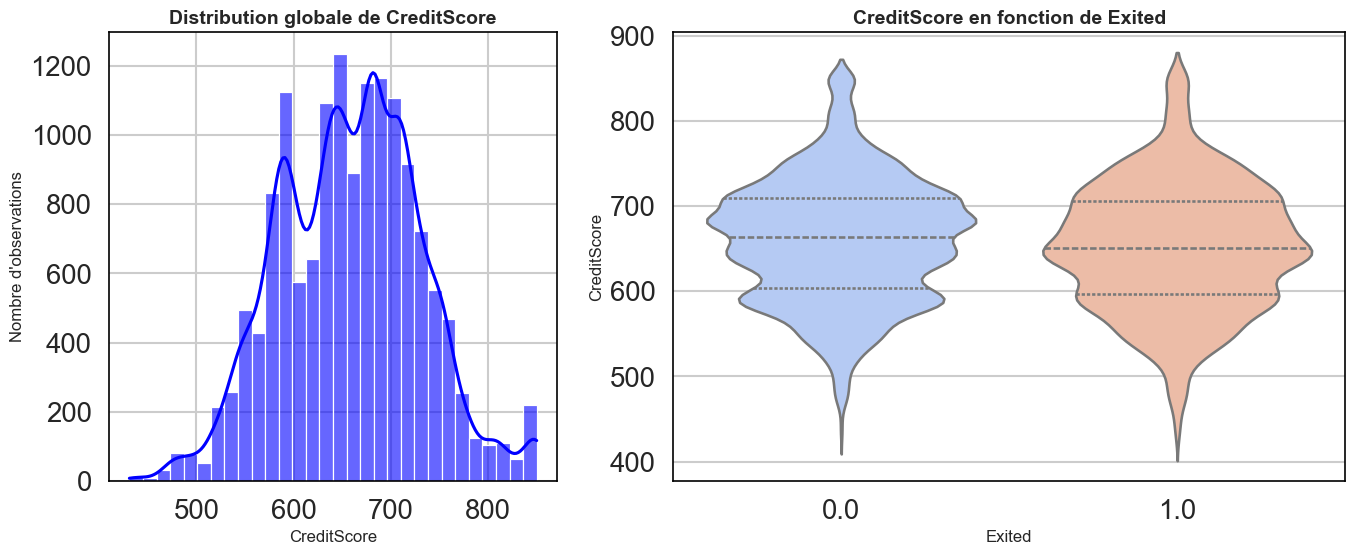

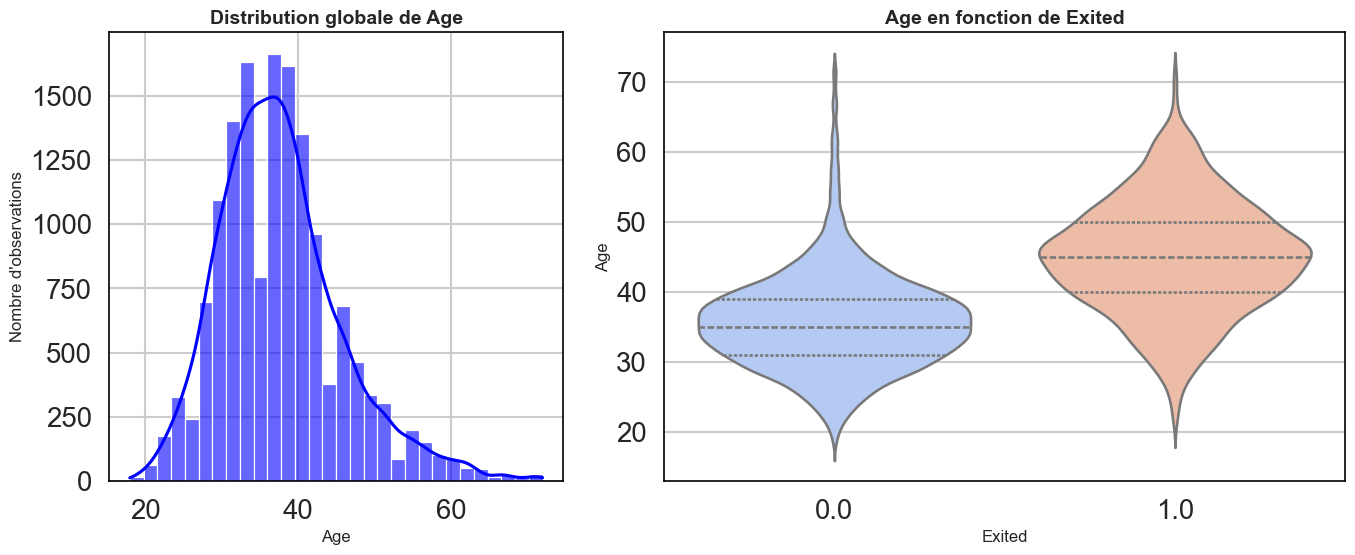

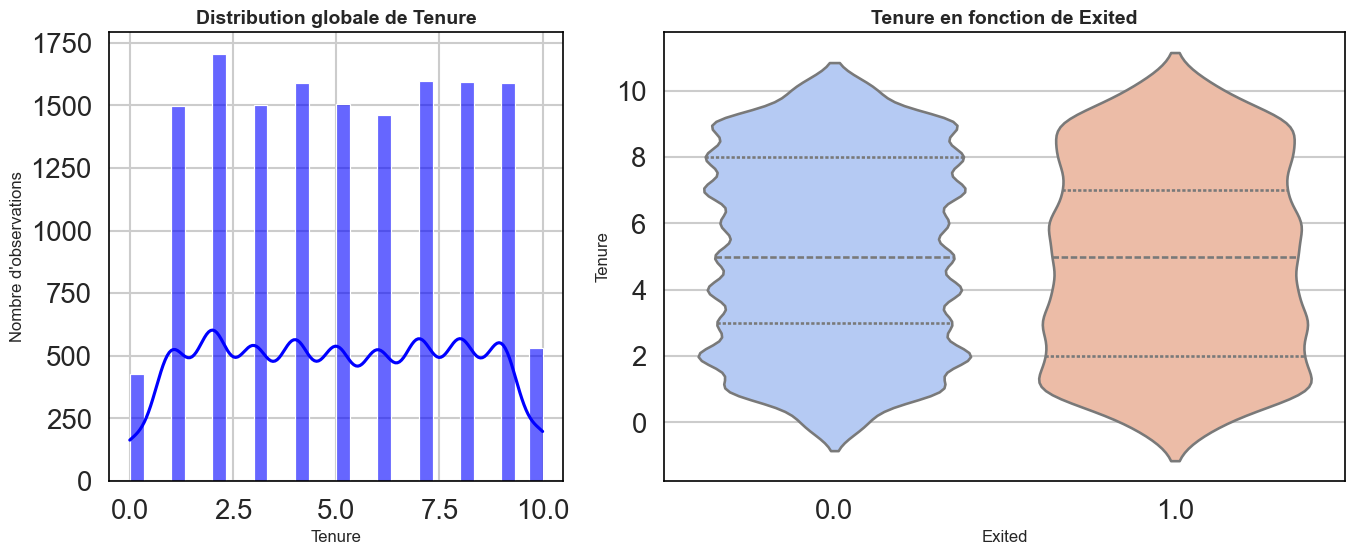

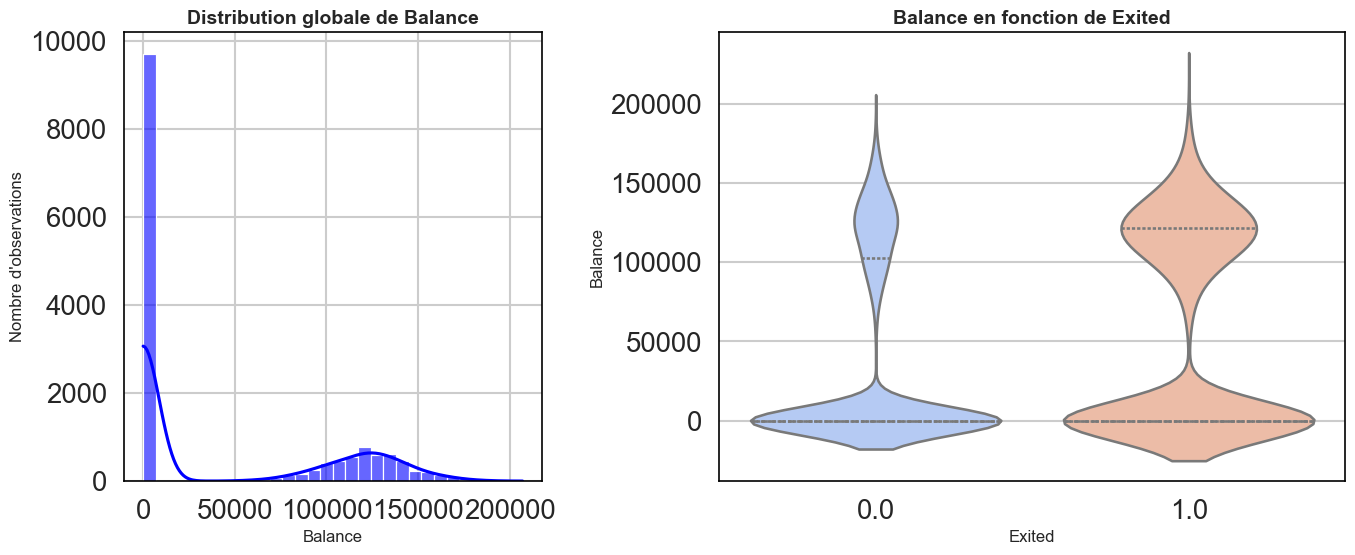

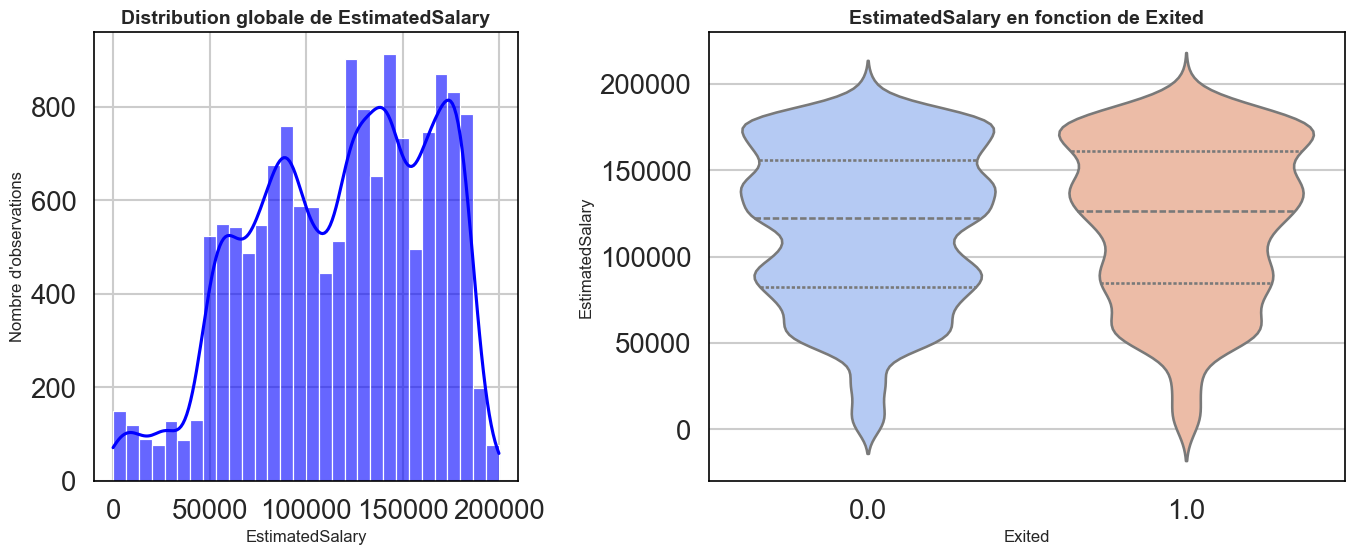

In [18]:
sns.set(style="whitegrid", context="talk", font_scale=1.2)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2

# Liste des variables numériques
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Visualisation des distributions
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [2, 3]})
    
    # Distribution globale (avec KDE)
    sns.histplot(train[col], kde=True, color='blue', bins=30, alpha=0.6, ax=axes[0])
    axes[0].set_title(f"Distribution globale de {col}", fontsize=14, fontweight="bold")
    axes[0].set_xlabel(col, fontsize=12)
    axes[0].set_ylabel("Nombre d'observations", fontsize=12)

    # Distribution par cible
    sns.violinplot(data=train, x='Exited', y=col, palette='coolwarm', inner='quartile', ax=axes[1])
    axes[1].set_title(f"{col} en fonction de Exited", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Exited", fontsize=12)
    axes[1].set_ylabel(col, fontsize=12)

    # Ajuster les espacements
    plt.tight_layout()
    plt.show()

# CreditScore

La variable présente une distribution normale avec une légère asymétrie à gauche. Les différences entre les groupes Exited sont faibles, ce qui ne justifie ni transformation ni catégorisation. Elle est conservée telle quelle pour capturer toute l’information disponible.

# Tenure

La variable est discrète avec des valeurs allant de 0 à 10 ans. Aucune relation significative avec le churn n’a été identifiée, mais elle est conservée telle quelle pour permettre aux modèles d’évaluer son importance.

# EstimatedSalary

La distribution est uniforme et aucune relation claire avec le churn n’a été identifiée. Elle est conservée telle quelle pour laisser les modèles évaluer sa pertinence sans transformation spécifique.

# Balance

Un grand nombre de clients ont un solde nul, ce qui peut indiquer une relation importante avec le churn. Une variable binaire sera ajoutée pour indiquer si le solde est nul, tout en gardant la version continue pour capturer les variations.

In [19]:
# --- Bloc 3 : Création de NoBalance ---
# Création une indicatrice pour Balance
train['NoBalance'] = (train['Balance'] == 0).astype(int)
test['NoBalance'] = (test['Balance'] == 0).astype(int)


In [20]:
# Ajout de NoBalance à CatBoost
train_cb["NoBalance"] = train["NoBalance"]
test_cb["NoBalance"] = test["NoBalance"]

# Ajout de NoBalance pour XGBoost/LightGBM
train_xgb_lgbm["NoBalance"] = train["NoBalance"]
test_xgb_lgbm["NoBalance"] = test["NoBalance"]

# Age

Les clients plus âgés sont plus susceptibles de quitter la banque, comme l’indique une nette différence entre les distributions par cible. Une catégorisation (binning) sera effectuée pour capturer des effets non linéaires, tout en conservant la version continue.

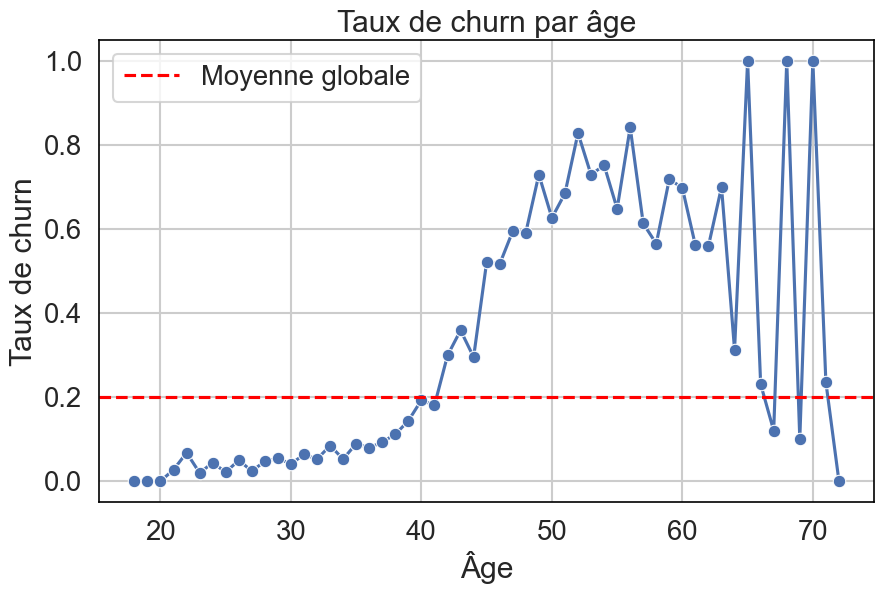

In [21]:
# Analyse du churn moyen par âge
age_churn = train.groupby('Age')['Exited'].mean().reset_index()

# Visualisation de la relation entre Age et churn
plt.figure(figsize=(10, 6))
sns.lineplot(data=age_churn, x='Age', y='Exited', marker="o")
plt.axhline(y=train['Exited'].mean(), color="red", linestyle="--", label="Moyenne globale")
plt.title("Taux de churn par âge")
plt.xlabel("Âge")
plt.ylabel("Taux de churn")
plt.legend()
plt.show()

In [24]:
# --- Bloc 4 : Binning de Age ---
# Création de bins d'âge basés sur le graphique
def categorize_age(age):
    if age <= 30:
        return "18-30"  # Jeunes adultes
    elif age <= 40:
        return "31-40"  # Adultes
    elif age <= 50:
        return "41-50"  # Milieu de carrière
    elif age <= 60:
        return "51-60"  # Seniors actifs
    else:
        return "61+"  # Retraités

# Application du binning à train et test
train["Age_bin"] = train["Age"].apply(categorize_age)
test["Age_bin"] = test["Age"].apply(categorize_age)

# Vérification des bins créés
print(train["Age_bin"].value_counts())

Age_bin
31-40    7868
41-50    3411
18-30    2617
51-60     887
61+       217
Name: count, dtype: int64


In [25]:
# Ajout de Age_bin à CatBoost
train_cb["Age_bin"] = train["Age_bin"]
test_cb["Age_bin"] = test["Age_bin"]

# Calcul du target encoding pour Age_bin
age_bin_target_mean = train.groupby("Age_bin")["Exited"].mean()

# Ajout de la version encodée de Age_bin pour XGBoost/LightGBM
train_xgb_lgbm["Age_bin_encode"] = train["Age_bin"].map(age_bin_target_mean)
test_xgb_lgbm["Age_bin_encode"] = test["Age_bin"].map(age_bin_target_mean)

# --- Bloc 5 : Vérification des DataFrames finaux ---
print("CatBoost DataFrame :")
print(train_cb.head())

print("XGBoost/LightGBM DataFrame :")
print(train_xgb_lgbm.head())

CatBoost DataFrame :
   CreditScore Geography  Gender   Age  Tenure    Balance  NumOfProducts  \
0        683.0   Germany    Male  49.0     7.0  123837.86            2.0   
1        608.0    France  Female  30.0    10.0       0.00            2.0   
2        539.0    France  Female  32.0     8.0       0.00            1.0   
3        530.0     Spain  Female  39.0     8.0       0.00            2.0   
4        613.0    France  Female  45.0    10.0       0.00            2.0   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  NoBalance Age_bin  
0        1.0             1.0        138700.75     1.0          0   41-50  
1        1.0             1.0        146723.72     0.0          1   18-30  
2        1.0             1.0         94873.60     0.0          1   31-40  
3        0.0             0.0        177896.93     0.0          1   31-40  
4        1.0             1.0        116748.14     0.0          1   41-50  
XGBoost/LightGBM DataFrame :
   CreditScore   Age  Tenure    Balance  Nu

In [26]:
# Afficher les types des variables pour train_cb (CatBoost)
print("Types des variables pour train_cb (CatBoost):")
print(train_cb.dtypes)

# Afficher les types des variables pour train_xgb_lgbm (XGBoost/LightGBM)
print("\nTypes des variables pour train_xgb_lgbm (XGBoost/LightGBM):")
print(train_xgb_lgbm.dtypes)

# Afficher les types des variables pour le dataset d'origine (train)
print("\nTypes des variables pour train (dataset d'origine):")
print(train.dtypes)

Types des variables pour train_cb (CatBoost):
CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
NoBalance            int32
Age_bin             object
dtype: object

Types des variables pour train_xgb_lgbm (XGBoost/LightGBM):
CreditScore         float64
Age                 float64
Tenure              float64
Balance             float64
NumOfProducts       float64
HasCrCard           float64
IsActiveMember      float64
EstimatedSalary     float64
Exited              float64
Geography_encode    float64
Gender_encode         int32
NoBalance             int32
Age_bin_encode      float64
dtype: object

Types des variables pour train (dataset d'origine):
CreditScore        float64
Geography           object
Gender              object
Age             

In [27]:
from sklearn.model_selection import StratifiedKFold

# Définir le nombre de splits pour la cross-validation
NB_SPLIT = 5
skf = StratifiedKFold(n_splits=NB_SPLIT, shuffle=True, random_state=42)

# Ajouter une colonne pour les folds dans train
train["fold"] = -1

# Appliquer StratifiedKFold sur les données de train
for fold, (train_idx, val_idx) in enumerate(skf.split(train, train["Exited"])):
    train.loc[val_idx, "fold"] = fold

# Vérification des répartitions dans les folds
print("\nRépartition des folds dans train :")
print(train["fold"].value_counts())

print("\nRépartition des classes par fold :")
print(pd.crosstab(train["fold"], train["Exited"]))

# Mettre à jour les DataFrames pour CatBoost
train_cb["fold"] = train["fold"]

# Mettre à jour les DataFrames pour XGBoost et LightGBM
train_xgb_lgbm["fold"] = train["fold"]


Répartition des folds dans train :
fold
2    3000
4    3000
0    3000
3    3000
1    3000
Name: count, dtype: int64

Répartition des classes par fold :
Exited   0.0  1.0
fold             
0       2402  598
1       2402  598
2       2402  598
3       2402  598
4       2402  598


# Catboost

In [28]:
# Validation croisée avec CatBoost
auc_scores_train = []
auc_scores_val = []

# Spécifiez les colonnes catégoriques
cat_features = ['Geography', 'Gender', 'Age_bin']  # Ajouter les colonnes catégoriques pertinentes

for fold in range(NB_SPLIT):
    print(f"\n--- Entraînement pour le Fold {fold} ---")

    train_data = train_cb[train_cb["fold"] != fold]
    val_data = train_cb[train_cb["fold"] == fold]

    X_train = train_data.drop(columns=['Exited', 'fold'])
    y_train = train_data['Exited']
    X_val = val_data.drop(columns=['Exited', 'fold'])
    y_val = val_data['Exited']

    # Modèle CatBoost avec colonnes catégoriques
    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        depth=6,
        random_seed=42,
        auto_class_weights='Balanced',
        verbose=0
    )

    # Entraînez le modèle en spécifiant les colonnes catégoriques
    model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), use_best_model=True)

    # AUC sur train
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    auc_train = roc_auc_score(y_train, y_train_pred_proba)
    auc_scores_train.append(auc_train)

    # AUC sur validation
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    auc_val = roc_auc_score(y_val, y_val_pred_proba)
    auc_scores_val.append(auc_val)

    print(f"AUC Train : {auc_train:.4f}, AUC Val : {auc_val:.4f}")

# Moyenne et écart-type des AUC
auc_mean_train = np.mean(auc_scores_train)
auc_std_train = np.std(auc_scores_train)
auc_mean_val = np.mean(auc_scores_val)
auc_std_val = np.std(auc_scores_val)

print("\nStatistiques des AUC sur Train :")
print(f"Moyenne = {auc_mean_train:.4f}, Écart-type = {auc_std_train:.4f}")

print("\nStatistiques des AUC sur Validation :")
print(f"Moyenne = {auc_mean_val:.4f}, Écart-type = {auc_std_val:.4f}")

# Décision sur l'homogénéité des folds
if auc_std_val < 0.01:
    print("\nLes folds sont homogènes (écart-type faible).")
else:
    print("\nAttention : Les folds présentent une certaine variabilité (écart-type élevé).")


--- Entraînement pour le Fold 0 ---
AUC Train : 0.9480, AUC Val : 0.9385

--- Entraînement pour le Fold 1 ---
AUC Train : 0.9490, AUC Val : 0.9444

--- Entraînement pour le Fold 2 ---
AUC Train : 0.9488, AUC Val : 0.9330

--- Entraînement pour le Fold 3 ---
AUC Train : 0.9535, AUC Val : 0.9337

--- Entraînement pour le Fold 4 ---
AUC Train : 0.9507, AUC Val : 0.9334

Statistiques des AUC sur Train :
Moyenne = 0.9500, Écart-type = 0.0020

Statistiques des AUC sur Validation :
Moyenne = 0.9366, Écart-type = 0.0044

Les folds sont homogènes (écart-type faible).


In [25]:

# Nombre de folds pour la validation croisée
NB_SPLIT = 5
skf = StratifiedKFold(n_splits=NB_SPLIT, shuffle=True, random_state=42)

# Fonction objective pour Optuna
def objective(trial):
    # Hyperparamètres à optimiser
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500, step=250),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.03),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'auto_class_weights': 'SqrtBalanced',
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'feature_border_type': trial.suggest_categorical(
            'feature_border_type', ['MinEntropy', 'GreedyLogSum', 'Uniform']
        ),
    }
    
    # Validation croisée
    auc_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_cb, train_cb['Exited'])):
        # Préparation des données
        train_data = train_cb.iloc[train_idx]
        val_data = train_cb.iloc[val_idx]
        
        X_train = train_data.drop(columns=['Exited', 'fold'])
        y_train = train_data['Exited']
        X_val = val_data.drop(columns=['Exited', 'fold'])
        y_val = val_data['Exited']
        
        # Entraînement du modèle
        model = CatBoostClassifier(**params, random_seed=42, verbose=0)
        model.fit(
            X_train,
            y_train,
            cat_features=['Geography', 'Gender', 'Age_bin'],
            eval_set=(X_val, y_val),
            use_best_model=True
        )
        
        # Prédictions et calcul de l'AUC
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        auc_scores.append(auc)
    
    # Retourner la moyenne des AUC pour l'objectif d'Optuna
    return np.mean(auc_scores)

# Création d'une étude Optuna
study = optuna.create_study(direction='maximize', study_name="CatBoost Optimization")
study.optimize(objective, n_trials=30, n_jobs=-1)

# Résultats de l'optimisation
print("\nMeilleurs hyperparamètres :")
print(study.best_params)
print(f"Meilleur score AUC moyen sur validation : {study.best_value:.4f}")

# Application des meilleurs hyperparamètres pour l'entraînement final
best_params = study.best_params
best_params['random_seed'] = 42
best_params['verbose'] = 100  # Permet d'afficher les logs pour le modèle final
best_params['auto_class_weights'] = 'SqrtBalanced'

final_model = CatBoostClassifier(**best_params)
final_model.fit(
    train_cb.drop(columns=['Exited', 'fold']),
    train_cb['Exited'],
    cat_features=['Geography', 'Gender', 'Age_bin']
)


[I 2025-01-01 23:44:34,953] A new study created in memory with name: CatBoost Optimization
[I 2025-01-02 00:03:40,565] Trial 10 finished with value: 0.9367345773728136 and parameters: {'iterations': 500, 'learning_rate': 0.023790314739297387, 'depth': 7, 'l2_leaf_reg': 8.947242940306303, 'bagging_temperature': 0.9799988010759013, 'border_count': 105, 'feature_border_type': 'Uniform'}. Best is trial 10 with value: 0.9367345773728136.
[I 2025-01-02 00:08:35,623] Trial 0 finished with value: 0.9362755117669501 and parameters: {'iterations': 500, 'learning_rate': 0.01341443994414666, 'depth': 8, 'l2_leaf_reg': 4.559582921642182, 'bagging_temperature': 0.8543323185734504, 'border_count': 66, 'feature_border_type': 'Uniform'}. Best is trial 10 with value: 0.9367345773728136.


# XGBoost

In [26]:

# Nombre de splits pour la validation croisée
NB_SPLIT = 5
skf = StratifiedKFold(n_splits=NB_SPLIT, shuffle=True, random_state=42)

# Hyperparamètres de base pour XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
}

# Stockage des scores AUC
auc_scores_train = []
auc_scores_val = []

# Validation croisée
for fold, (train_idx, val_idx) in enumerate(skf.split(train_xgb_lgbm, train_xgb_lgbm['Exited'])):
    print(f"\n--- Entraînement pour le Fold {fold + 1} ---")
    
    # Préparation des données
    train_data = train_xgb_lgbm.iloc[train_idx]
    val_data = train_xgb_lgbm.iloc[val_idx]

    X_train = train_data.drop(columns=['Exited', 'fold'])
    y_train = train_data['Exited']
    X_val = val_data.drop(columns=['Exited', 'fold'])
    y_val = val_data['Exited']

    # DMatrix pour XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Entraînement du modèle
    model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=100,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Prédictions et calcul de l'AUC
    y_train_pred_proba = model.predict(dtrain)
    auc_train = roc_auc_score(y_train, y_train_pred_proba)
    auc_scores_train.append(auc_train)

    y_val_pred_proba = model.predict(dval)
    auc_val = roc_auc_score(y_val, y_val_pred_proba)
    auc_scores_val.append(auc_val)

    print(f"AUC Train : {auc_train:.4f}, AUC Validation : {auc_val:.4f}")

# Moyennes et écarts-types des scores AUC
auc_mean_train = np.mean(auc_scores_train)
auc_std_train = np.std(auc_scores_train)
auc_mean_val = np.mean(auc_scores_val)
auc_std_val = np.std(auc_scores_val)

print("\nStatistiques des AUC pour XGBoost :")
print(f"AUC Train - Moyenne : {auc_mean_train:.4f}, Écart-type : {auc_std_train:.4f}")
print(f"AUC Validation - Moyenne : {auc_mean_val:.4f}, Écart-type : {auc_std_val:.4f}")

# Vérification de l'homogénéité des folds
if auc_std_val < 0.01:
    print("\nLes folds sont homogènes.")
else:
    print("\nAttention : Variabilité détectée entre les folds.")


--- Entraînement pour le Fold 1 ---
AUC Train : 0.9527, AUC Validation : 0.9384

--- Entraînement pour le Fold 2 ---
AUC Train : 0.9582, AUC Validation : 0.9420

--- Entraînement pour le Fold 3 ---
AUC Train : 0.9655, AUC Validation : 0.9309

--- Entraînement pour le Fold 4 ---
AUC Train : 0.9564, AUC Validation : 0.9308

--- Entraînement pour le Fold 5 ---
AUC Train : 0.9571, AUC Validation : 0.9320

Statistiques des AUC pour XGBoost :
AUC Train - Moyenne : 0.9580, Écart-type : 0.0042
AUC Validation - Moyenne : 0.9348, Écart-type : 0.0046

Les folds sont homogènes.


In [29]:



# Nombre de folds pour la validation croisée
NB_SPLIT = 5
skf = StratifiedKFold(n_splits=NB_SPLIT, shuffle=True, random_state=42)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'lambda': trial.suggest_float('lambda', 0.01, 10, log=True),
        'alpha': trial.suggest_float('alpha', 0.01, 10, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 5),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'seed': 42
    }

    auc_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_xgb_lgbm, train_xgb_lgbm['Exited'])):
        train_data = train_xgb_lgbm.iloc[train_idx]
        val_data = train_xgb_lgbm.iloc[val_idx]

        X_train = train_data.drop(columns=['Exited', 'fold'])
        y_train = train_data['Exited']
        X_val = val_data.drop(columns=['Exited', 'fold'])
        y_val = val_data['Exited']

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dval, 'validation')],
            early_stopping_rounds=30,
            verbose_eval=False
        )

        y_val_pred = model.predict(dval)
        auc = roc_auc_score(y_val, y_val_pred)
        auc_scores.append(auc)

    return np.mean(auc_scores)

study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost Optimization")
study_xgb.optimize(objective, n_trials=150, n_jobs=-1)  # Augmenté à 150 essais

# Afficher les meilleurs hyperparamètres et le meilleur score
print("\nMeilleurs hyperparamètres pour XGBoost :", study_xgb.best_params)
print("Meilleure AUC moyenne sur validation :", study_xgb.best_value)

# Entraîner le modèle final avec les meilleurs hyperparamètres
# Application des meilleurs hyperparamètres pour XGBoost
best_params_xgb = study_xgb.best_params
best_params_xgb['eval_metric'] = 'auc'  # Ajouter le paramètre eval_metric ici
best_params_xgb['use_label_encoder'] = False
best_params_xgb['verbosity'] = 1

final_model_xgb = xgb.XGBClassifier(**best_params_xgb)

# Entraînement du modèle final
final_model_xgb.fit(
    train_xgb_lgbm.drop(columns=['Exited', 'fold']),
    train_xgb_lgbm['Exited']
)

[I 2024-12-21 19:47:14,632] A new study created in memory with name: XGBoost Optimization
[I 2024-12-21 19:47:16,007] Trial 3 finished with value: 0.9146786123046848 and parameters: {'learning_rate': 0.0041947329956018055, 'max_depth': 11, 'min_child_weight': 6.473045508627347, 'gamma': 8.239181237418535, 'subsample': 0.7248182586712979, 'colsample_bytree': 0.3632934878227235, 'lambda': 2.3826209812472916, 'alpha': 3.0167130670001976, 'scale_pos_weight': 1.1496394608473137, 'max_delta_step': 5}. Best is trial 3 with value: 0.9146786123046848.
[I 2024-12-21 19:47:16,153] Trial 0 finished with value: 0.9155647885402075 and parameters: {'learning_rate': 0.013191726457127795, 'max_depth': 3, 'min_child_weight': 19.203499565312804, 'gamma': 8.776611147426742, 'subsample': 0.9072941671358763, 'colsample_bytree': 0.370262448677962, 'lambda': 0.067179018776504, 'alpha': 0.029170737052800825, 'scale_pos_weight': 4.890580670134067, 'max_delta_step': 4}. Best is trial 0 with value: 0.915564788540


Meilleurs hyperparamètres pour XGBoost : {'learning_rate': 0.05836123381020582, 'max_depth': 5, 'min_child_weight': 11.153968348981442, 'gamma': 9.200958758108449, 'subsample': 0.8441648810564072, 'colsample_bytree': 0.5456578586028333, 'lambda': 4.531975056100352, 'alpha': 0.6394603532180707, 'scale_pos_weight': 4.072833736490748, 'max_delta_step': 6}
Meilleure AUC moyenne sur validation : 0.9367352039409745


XGBClassifier(alpha=0.6394603532180707, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5456578586028333, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=9.200958758108449,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=4.531975056100352,
              learning_rate=0.05836123381020582, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=6,
              max_depth=5, max_leaves=None, min_child_weight=11.153968348981442,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=None, n_jobs=None, ...)

# LightGBM

In [ ]:

# Nombre de folds pour la validation croisée
NB_SPLIT = 5
skf = StratifiedKFold(n_splits=NB_SPLIT, shuffle=True, random_state=42)

# Fonction objective pour Optuna
def objective_lgbm(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e1, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'seed': 42
    }

    auc_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_xgb_lgbm, train_xgb_lgbm['Exited'])):
        train_data = train_xgb_lgbm.iloc[train_idx]
        val_data = train_xgb_lgbm.iloc[val_idx]

        X_train = train_data.drop(columns=['Exited', 'fold'])
        y_train = train_data['Exited']
        X_val = val_data.drop(columns=['Exited', 'fold'])
        y_val = val_data['Exited']

        train_set = lgb.Dataset(X_train, label=y_train)
        val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)

        model = lgb.train(
            params,
            train_set,
            num_boost_round=1000,
            valid_sets=[train_set, val_set],
            early_stopping_rounds=30,
            verbose_eval=False
        )

        y_val_pred = model.predict(X_val)
        auc = roc_auc_score(y_val, y_val_pred)
        auc_scores.append(auc)

    return np.mean(auc_scores)

# Création d'une étude Optuna
study_lgbm = optuna.create_study(direction='maximize', study_name="LightGBM Optimization")
study_lgbm.optimize(objective_lgbm, n_trials=150, n_jobs=-1)

# Afficher les meilleurs hyperparamètres et le meilleur score
print("\nMeilleurs hyperparamètres pour LightGBM :", study_lgbm.best_params)
print("Meilleure AUC moyenne sur validation :", study_lgbm.best_value)

# Entraîner le modèle final avec les meilleurs hyperparamètres
best_params_lgbm = study_lgbm.best_params
final_model_lgbm = lgb.LGBMClassifier(**best_params_lgbm)
final_model_lgbm.fit(
    train_xgb_lgbm.drop(columns=['Exited', 'fold']),
    train_xgb_lgbm['Exited']
)